**LIVE WEBCAM GENDER DETECTION**

Installing and importing the necessary libraries.
Also importing our pretrained model saved in mydrive

In [1]:
!pip install opencv-python-headless==4.8.0.76

from IPython import get_ipython
from IPython.display import display,Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
from keras.models import load_model  # Replace with appropriate library for your model
from google.colab import drive
import matplotlib.pyplot as plt
# Mount Google Drive

# Mount Google Drive
drive.mount('/content/drive')

# Navigate to the folder containing your model
# Load your gender detection model
model = load_model('/content/drive/MyDrive/gender_detection_model.h5')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 7.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.10.0.84
    Uninstalling opencv-python-headless-4.10.0.84:
      Successfully uninstalled opencv-python-headless-4.10.0.84
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.19 requires opencv-python-headless>=4.9.0.80, but you have opencv-python-headless 4.8.0.76 which is incompatible.
albumentations 1.4.20 requires opencv-python-headless>=4.9.0.80, but you have opencv-python-headless 4.8.0.76 which is incompatible.
Mounted at /content/drive


Using a Java script code in order to capture our image in webcam

<IPython.core.display.Javascript object>

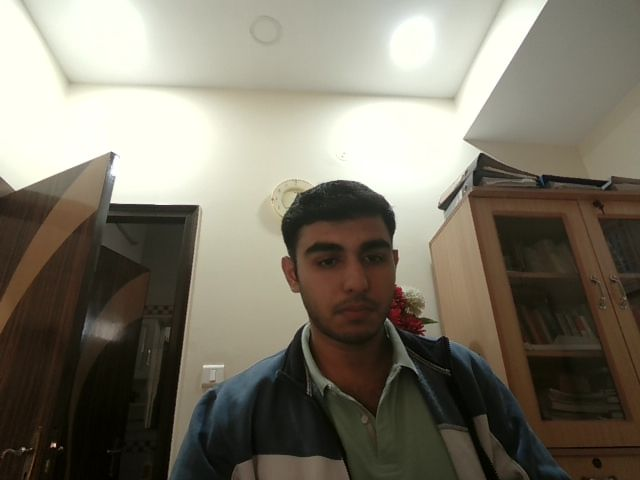

In [2]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
from PIL import Image
import io
import numpy as np

def take_photo_live():
  js = Javascript('''
    async function takePhoto() {
      const div = document.createElement('div');
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => {
        const button = document.createElement('button');
        button.textContent = 'Capture';
        button.style.padding = '5px';
        button.style.margin = '5px';
        button.style.border = '1px solid black';
        button.style.borderRadius = '5px';
        button.style.cursor = 'pointer';
        button.onclick = () => {
          resolve(stream);
        };
        div.appendChild(button);
      });

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', 0.8);
    }
    ''')
  display(js)
  data = eval_js('takePhoto()')
  binary = b64decode(data.split(',')[1])
  img = np.array(Image.open(io.BytesIO(binary)))
  return img

# Capture and display the live photo
live_photo = take_photo_live()
display(Image.fromarray(live_photo))

Using Haar Cascade for detecting the faces in our image and then  preprocessing the detected image frame and then predicting the gender of the image using our earlier used function of detect and predict gender

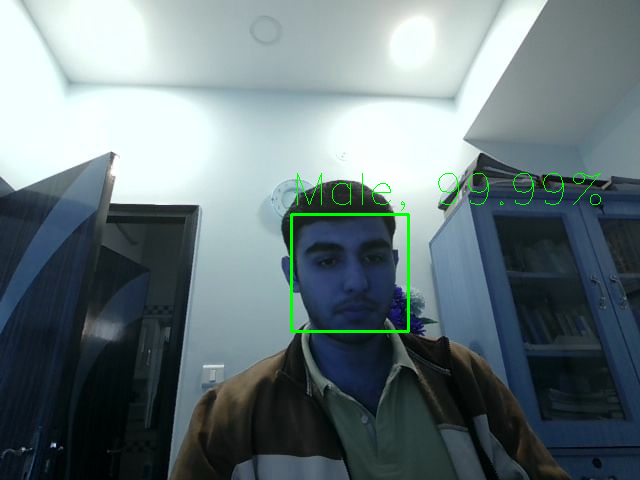

In [4]:
import cv2
import numpy as np
from PIL import Image
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
def preprocess_frame(frame):
    # Resizing the image
    resized_frame = cv2.resize(frame, (150, 150))
    # Normalization
    normalized_frame = resized_frame / 255.0
    preprocessed_frame = np.expand_dims(normalized_frame, axis=0)
    return preprocessed_frame

# Function to detect faces and predict gender
def detect_and_predict_gender(frame, model, face_cascade):
    # Converting the frame to grayscale for face detection by HAAR cascade
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detection
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # going through all the detected faces
    for (x, y, w, h) in faces:
        # Drawing a rectangle around the face
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

        #Preprocessing the face
        face_img = frame[y:y + h, x:x + w]
        preprocessed_face = preprocess_frame(face_img)

        # Predicting gender using the model and getting the prediction as a sigmoid function from 0 to 1
        prediction = model.predict(preprocessed_face)

        # Determining gender
        gender = 'Female' if prediction[0] > 0.5 else 'Male'
        probability = (prediction[0] * 100).item() if prediction[0] > 0.5 else ((1 - prediction[0]) * 100).item()

        # Creating  a label for display(that is label for gender and for probability)
        label = f"{gender}, {probability:.2f}%"
        cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 1)

    return frame

# Performing gender detection on the live photo captured by our webcam
output_frame = detect_and_predict_gender(live_photo, model, face_cascade)

# Displaying the output
display(Image.fromarray(cv2.cvtColor(output_frame, cv2.COLOR_BGR2RGB)))